In [1]:
import numpy as np
import matplotlib.pyplot as plt
import contextlib as cl
import time

import readdy._internal as api
import readdy._internal.readdybinding.api.top as top
api.set_logging_level("debug")

sim = api.Simulation()
sim.set_kernel("SingleCPU")

In [2]:
sim.periodic_boundary = [False, False, False]
sim.kbt = 0.8
sim.box_size = api.Vec(60., 60., 10.)

# register particle type
particle_radius = 0.5
sim.register_particle_type("head", diffusion_coefficient=.5, radius=2.*particle_radius, flavor=api.ParticleTypeFlavor.TOPOLOGY)
sim.register_particle_type("tail", diffusion_coefficient=.5, radius=particle_radius, flavor=api.ParticleTypeFlavor.TOPOLOGY)

# the potential that confines particles
origin = np.array([-28.,-28.,-0.001])
extent = np.array([54.,54.,0.002])
sim.register_potential_box("head", 200., api.Vec(*origin), api.Vec(*extent), False)
sim.register_potential_box("tail", 200., api.Vec(*origin), api.Vec(*extent), False)

# the pairwise interaction
sim.register_potential_piecewise_weak_interaction(
    "tail", "tail", force_constant=30., desired_particle_distance=2.*particle_radius, 
    depth=2.0, no_interaction_distance=4.*particle_radius
)
sim.register_potential_harmonic_repulsion("head", "head", force_constant=30.)


3

In [4]:
# topologies configuration
sim.configure_topology_bond_potential("head", "tail", force_constant=50, length=1.)
sim.configure_topology_bond_potential("tail", "tail", force_constant=50, length=1.)

In [5]:
# adding the topologies
rnd = np.random.uniform
for i in range(50):
    particles = []
    pos = origin + rnd(size=3) * extent
    particles.append(sim.create_topology_particle("head", api.Vec(*pos)))
    tail_orientation = rnd(size=3)
    particles.append(sim.create_topology_particle("tail", api.Vec(*(pos + tail_orientation))))
    particles.append(sim.create_topology_particle("tail", api.Vec(*(pos + 2.*tail_orientation))))
    topology = sim.add_topology(particles)
    topology.get_graph().add_edge(0, 1)
    topology.get_graph().add_edge(1, 2)

In [6]:
# define observables and run
traj_handle = sim.register_observable_flat_trajectory(stride=10)

particles_data = []
def get_particles(x):
    global particles_data
    particles_data.append(x)

handle = sim.register_observable_particles(stride=100, callback=get_particles)
    
with cl.closing(api.File("./obs.h5", api.FileAction.CREATE, api.FileFlag.OVERWRITE)) as f:
    traj_handle.enable_write_to_file(file=f, data_set_name="traj", chunk_size=10000)
    t1 = time.perf_counter()
    sim.run_scheme_readdy(True) \
        .write_config_to_file(f) \
        .with_reaction_scheduler("UncontrolledApproximation") \
        .configure_and_run(400000, 0.005)
    t2 = time.perf_counter()
print("Simulated", t2 - t1, "seconds")

Simulated 126.37303330499981 seconds


In [7]:
# convert trajectory
t1 = time.perf_counter()
api.convert_xyz("./obs.h5", "traj", "./traj.xyz", radii={"head": 2.*particle_radius, "tail": particle_radius})
t2 = time.perf_counter()
print("Conversion took", t2 - t1, "seconds")

Conversion took 11.025460414000008 seconds


In [8]:
def get_msd(particles_data):
    # obtain positions and ids as numpy arrays
    positions = []
    ids = []
    for t in range(len(particles_data)):
        positions.append(
            np.array([[x[0], x[1], x[2]] for x in particles_data[t][2]])
        )
        ids.append(
            np.array([x for x in particles_data[t][1]])
        )
    positions = np.array(positions)
    ids = np.array(ids)

    # sort the positions with respect to ids in each timestep,
    # since they might have changed the index in the positions array
    sorted_positions = np.zeros_like(positions)
    for t in range(len(ids)):
        sort_indices = np.argsort(ids[t])
        sorted_positions[t] = positions[t][sort_indices]

    # calculate the actual msd
    difference = sorted_positions - sorted_positions[0]
    squared = difference * difference
    squared_deviation = np.sum(squared, axis=2)
    n_particles = sorted_positions.shape[1]
    mean_squared_deviation = np.sum(squared_deviation, axis=1) / n_particles
    return mean_squared_deviation

In [9]:
msd = get_msd(particles_data)

In [10]:
msd.shape

(4001,)

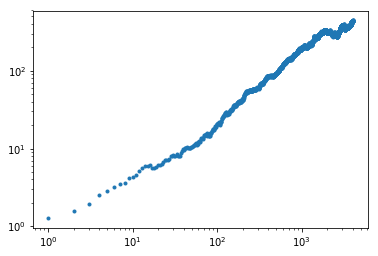

In [12]:
plt.plot(range(len(msd)), msd, ".")
plt.xscale("log")
plt.yscale("log")
plt.show()